# 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.ndimage import gaussian_filter

# Plotting
import cmocean
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
color_map = cmocean.cm.ice

# Methods
from s4hci.models.psf_subtraction import S4
from s4hci.utils.pca import pca_psf_subtraction_gpu

from s4hci.utils.data_handling import save_as_fits
from applefy.utils.file_handling import load_adi_data
from s4hci.utils.data_handling import read_s4hci_root_dir

# Evaluation
from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, fpf_2_gaussian_sigma, gaussian_sigma_2_fpf

# 2. Load the Dataset

In [2]:
root_dir = Path(read_s4hci_root_dir())

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
dataset_file = root_dir / Path("30_data/HD35850_294_088_C-0085_A_.hdf5")
experiment_root_dir = root_dir / Path("70_results/x2_af_lep/")

In [4]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_selected",
    psf_template_tag="psf_selected",
    para_tag="header_object_selected/PARANG")

science_data = science_data[:, 25:-25, 25:-25]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)

In [5]:
fwhm = 3.6
pixel_scale = 0.0271

## 2.1 Temporal binning

In [6]:
binning = 5  # stack every 5 frames
angles_stacked = np.array([
    np.mean(i) 
    for i in np.array_split(angles, int(len(angles) / binning))])
science_stacked = np.array([
    np.mean(i, axis=0) 
    for i in np.array_split(science_data, int(len(angles) / binning))])

# 3. Run $S^4$

In [7]:
lambda_reg = 25000

In [8]:
work_dir = experiment_root_dir / Path("S4")
work_dir.mkdir(exist_ok=True)

In [9]:
s4_model = S4(
    science_cube=science_stacked,
    adi_angles=angles_stacked,
    psf_template=psf_template_data,
    device=0,
    work_dir=work_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda_init=lambda_reg,
    noise_cut_radius_psf=fwhm,
    noise_mask_radius=fwhm*1.5,
    noise_normalization="normal",
    noise_model_convolve=True)

In [10]:
s4_model.fit_noise_model(
    num_epochs=100,
    use_rotation_loss=True,
    training_name="AF_Lep_" + str(lambda_reg),
    logging_interval=1)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [11]:
s4_residual = s4_model.compute_residual(combine="mean")

S4 model: computing residual ... [DONE]


# 4. Compute the S/N

In [12]:
position  = (68.55, 54.78) # Result from MCMC
# Use pixel values spaced by the FWHM
photometry_mode_planet = AperturePhotometryMode("FS", search_area=1.0, psf_fwhm_radius=fwhm/2)
photometry_mode_noise = AperturePhotometryMode("P")

In [13]:
_, _, snr_mean = compute_detection_uncertainty(
    frame=s4_residual,
    planet_position=position, 
    statistical_test=TTest(),
    psf_fwhm_radius=fwhm,
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise,
    safety_margin=1.,
    num_rot_iter=50)
    
print("S4 reaches a S/N of " + str(np.round(np.mean(snr_mean), 1)))

S4 reaches a S/N of 6.7


# 5. Compute PCA

In [14]:
num_components = [20, 60]

In [15]:
pca_residuals = pca_psf_subtraction_gpu(
    images=science_stacked,
    angles=angles_stacked,
    pca_numbers=num_components,
    device=0,
    approx_svd=2000,
    verbose = True)

Compute PCA basis ...[DONE]
Compute PCA residuals ...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.64it/s]

[DONE]


# 6. Create the plot

In [16]:
def get_xy_position(angle, distance_arsec, center):
    angle_radians = np.deg2rad(angle - 90)
    distance = distance_arsec /pixel_scale

    # Calculate x and y coordinates
    x = distance * np.cos(angle_radians)
    y = distance * np.sin(angle_radians)
    
    return center - x, center - y

In [28]:
def plot_residual(
    axis_in,
    residual_frame,
    zoom=10):
    
    median= np.median(residual_frame)
    scale = np.max(np.abs(residual_frame))

    axis_in.imshow(
        residual_frame[zoom:-zoom, zoom:-zoom],
        cmap=color_map,
        vmin=median - scale*0.5, vmax=median + scale,
        origin="lower")
    
    axis_in.set_xticks([])
    axis_in.set_yticks([])
    
    center = int(residual_frame[zoom:-zoom, zoom:-zoom].shape[0] / 2)
    axis_in.scatter(center, center, c='w', marker='*', s=30)
    
    size_position = 5
    axis_in.hlines([5, ], 
                 xmin=size_position, 
                 xmax=size_position + int(0.5 / pixel_scale),
                 color='w', lw=2)
    axis_in.text(
        x=size_position +int(0.5 / pixel_scale / 2) , 
        y=7, 
        s='0.5"', color='w', ha='center', va='bottom', 
        fontsize=10,
        fontweight="bold")

    axis_in.vlines(x=90, ymin=5, ymax=15, color='w')
    axis_in.hlines(y=5, xmin=80, xmax=90, color='w')
    axis_in.text(x=90, y=15, s='N', color='w', ha='center', va='bottom', fontsize=10)
    axis_in.text(x=78, y=5, s='E', color='w', ha='right', va='center', fontsize=10)

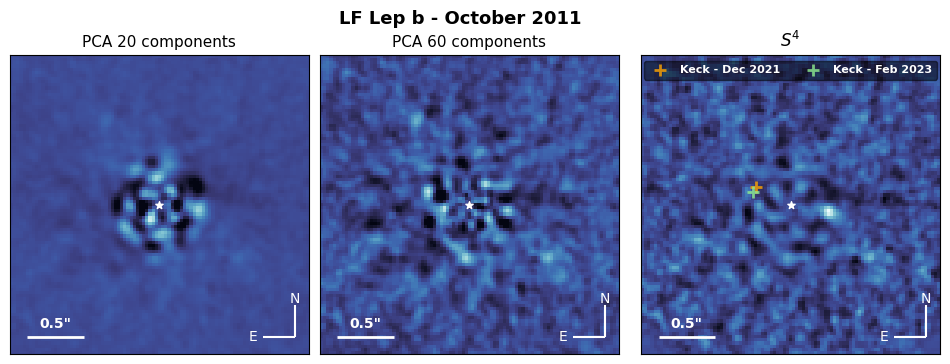

In [32]:
# --------------------------------------------------------------------
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 6))
gs0 = fig.add_gridspec(1, 4, width_ratios=[1, 1,  0.0, 1])
gs0.update(hspace=0.0, wspace=0.05)

ax_pca1 = fig.add_subplot(gs0[0])
ax_pca2 = fig.add_subplot(gs0[1])
ax_s4 = fig.add_subplot(gs0[3])

# --------------------------------------------------------------------
# 2.) Plot the residuals
plot_residual(ax_pca1, gaussian_filter(
    pca_residuals[0], sigma=(0.8, 0.8),order=0))
plot_residual(ax_pca2, gaussian_filter(
    pca_residuals[1], sigma=(0.8, 0.8),order=0))
plot_residual(ax_s4, gaussian_filter(
    s4_residual, sigma=(0.8, 0.8), order=0))

# --------------------------------------------------------------------
# 3.) Mark the Keck observations
zoom = 10
center = int(s4_residual[zoom:-zoom, zoom:-zoom].shape[0] / 2)
ax_s4.scatter(*get_xy_position(62.8, 0.338, center),
              marker="+",
              color="orange",
              alpha=0.8, lw=2,
              label="Keck - Dec 2021",
              s=80)

ax_s4.scatter(*get_xy_position(72.0, 0.342, center), 
              marker="+",
              color="lightgreen", 
              alpha=0.8, lw=2,
              label="Keck - Feb 2023",
              s=80)

# --------------------------------------------------------------------
# 4.) Add the Legend
lgd = ax_s4.legend(
    ncol=2, fontsize=8,
    loc='lower center',
    framealpha=0.5,
    facecolor=(0, 0, 0, 0),
    edgecolor=(0, 0, 0, 0),
    labelcolor='white',
    prop={'weight': 'bold',
          'size' : 8},
    bbox_to_anchor=(0.5, 0.9))

# --------------------------------------------------------------------
# 5.) Add Titles
ax_s4.set_title("$S^4$", fontsize=12)
ax_pca1.set_title("PCA 20 components", fontsize=11)
ax_pca2.set_title("PCA 60 components", fontsize=11)

st = fig.suptitle(
    "LF Lep b - October 2011",
    fontsize=13, fontweight="bold", y=0.82)

# 6.) Save the figure
plt.savefig("./final_plots/06_AF_Lep.pdf",
            bbox_extra_artists=(st,),
            bbox_inches='tight')